In [19]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l
import collections
import re
import random

d2l.gpu_mem_init()

Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [20]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [21]:
def get_lstm_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        #原书中例子代码中stddev=0.01,导致训练一直不能收敛，改成0.1后，顺利收敛
        return tf.Variable(tf.random.normal(shape, mean=0.0, stddev=0.1, dtype=tf.float32))

    def three():
        return (
            tf.Variable(normal((num_inputs, num_hiddens))),
            tf.Variable(normal((num_hiddens, num_hiddens))),
            tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32)
        )

    W_xi, W_hi, b_i = three() #输入门
    W_xf, W_hf, b_f = three() #遗忘门
    W_xo, W_ho, b_o = three() #输出门
    W_xc, W_hc, b_c = three() #候选记忆单元

    W_hq = tf.Variable(normal((num_hiddens, num_outputs)))
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)

    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]
    return params

In [22]:
def init_lstm_state(batch_size, num_hiddens):
    return (
        tf.Variable(tf.zeros((batch_size, num_hiddens))),
        tf.Variable(tf.zeros((batch_size, num_hiddens)))
    )

In [23]:
def lstm(inputs, state, params):
    W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q = params
    (H, C) = state
    outputs = []
    for X in inputs:
        X = tf.reshape(X, [-1, W_xi.shape[0]])
        I = tf.sigmoid(tf.matmul(X, W_xi) + tf.matmul(H, W_hi) + b_i)
        F = tf.sigmoid(tf.matmul(X, W_xf) + tf.matmul(H, W_hf) + b_f)
        O = tf.sigmoid(tf.matmul(X, W_xo) + tf.matmul(H, W_ho) + b_o)
        C_candidate = tf.tanh(tf.matmul(X, W_xc) + tf.matmul(H, W_hc) + b_c)
        C = F * C + I * C_candidate
        H = O * tf.tanh(C)
        Y = tf.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return tf.concat(outputs, axis=0), (H,C)

困惑度 1.0, 487.4 词元/秒 /GPU:0
time traveller with a slight accession ofcheerfulness really this
traveller with a slight accession ofcheerfulness really this


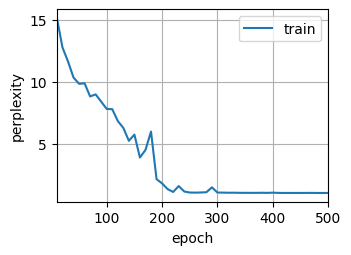

In [24]:
vocab_size, num_hiddens, device_name = len(vocab), 256, d2l.try_gpu()._device_name
num_epochs, lr = 500, 6.0
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
    model = d2l.RNNModelScratch(len(vocab), num_hiddens, init_lstm_state, lstm, get_lstm_params)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, strategy)